In [131]:
# Loading in the Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gamma

# Allows for the hot reloading of modules
%load_ext autoreload
%autoreload 2

# Loading in the Simulation Objects
from src.Centrifugation import *
from src.DataLoader import load_data_from_txt, normalize_data, load_data_from_excel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Centrifugation parms
duration = 10 # (min)
arm_length = 10 * 1e-2 # length of centrifuge 10cm  (m)
length = 1 * 1e-2 # tube length 1cm (m)

# Liquid parms
liquid_density = 997 # water (kg/m^2)
liquid_viscosity = 1 # water (mPa.s)

# Particle parms
particle_density = 2330 # silicon (kg.m^2)

    Radii(nm)           4ks       4kp           2kp       1kp       Raw
0          10  1.949689e-03  0.000953  3.706967e-04  0.098682  0.001426
1          20  3.069084e-05  0.000009  1.461382e-06  0.008008  0.000023
2          30  1.956195e-05  0.000008  2.531706e-07  0.442510  0.000016
3          40  3.410038e-04  0.114890  1.788848e-07  0.001172  0.002224
4          50  7.879400e-01  0.000067  3.688587e-07  0.000329  0.453205
5          60  2.279178e-03  0.500936  5.317645e-01  0.001605  0.266709
6          70  1.764135e-01  0.104664  2.359044e-05  0.294507  0.165469
7          80  7.557159e-03  0.087686  1.541846e-01  0.001061  0.037084
8          90  6.181364e-03  0.079994  1.079070e-01  0.080228  0.024373
9         100  1.728227e-02  0.075967  1.104010e-01  0.000770  0.030784
10        110  5.146861e-06  0.021689  7.548967e-02  0.071095  0.014018
11        120  2.579178e-07  0.005273  1.860746e-05  0.000025  0.004439
12        130  9.892162e-08  0.007828  1.983807e-02  0.000003  0

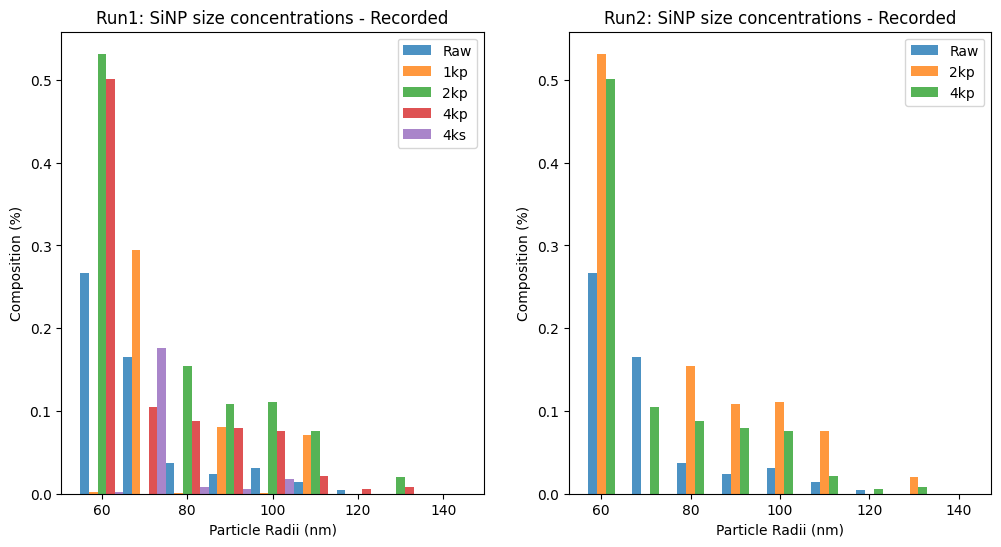

In [87]:
# Importing the data
data = load_data_from_excel('data/Centrifugation/centrifugation_2023.xlsx', load_all_sheets=True)
run1 = data['run1']
run2 = data['run2']

fig = plot_centrifuge_data(run1, run2, mask_limit=50, bar_width = 2)
print(run1)

0.0


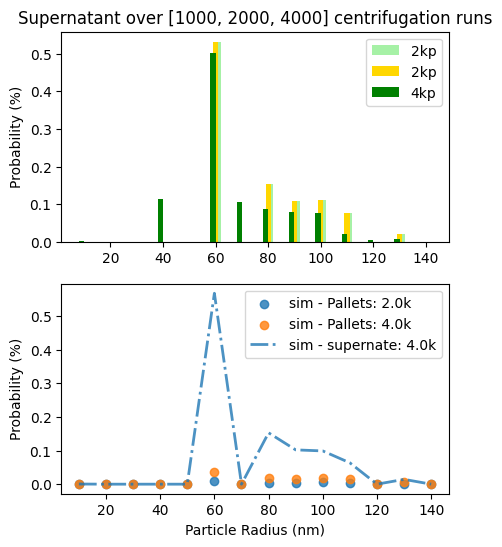

In [51]:
# How does the recorded size distribution change over time compared to the model?
mask = run1['Radii(nm)'] > 0

runs = [1000, 2000, 4000]
count = len(run2['Radii(nm)'][mask])
size = run2['Radii(nm)'][mask].to_numpy() * 1e-9

prob = run2['2kp'][mask].to_numpy()


pallets = np.zeros(count)

fig, ax = plt.subplots(2, figsize=(5,6))

ax[0].bar(size*1e9 + 1, prob, label=f"2kp", alpha = 0.8, width=2, color='lightgreen')
ax[0].bar(size*1e9, run2['2kp'][mask].to_numpy(), color = 'gold', label='2kp', width=2)
ax[0].bar(size*1e9 -1, run2['4kp'][mask].to_numpy(), color = 'green', label='4kp', width=2)
# ax[0].plot(size*1e9 -1, run2['4ks'][mask].to_numpy(), color = 'green', label='4ks', linestyle="-.")

print(sum(pallets))

 
for RPM in runs:
    prob_hold = prob.copy()
    pallets = np.zeros(count)
    
    for i in range(count):
        prob[i], pallets[i] = cal_supernate_and_pallets(size[i], prob[i], duration,
                                              particle_density, liquid_density, liquid_viscosity,
                                             RPM, arm_length, length) 

    # Normalising the calcuated values
#     prob = prob / sum(prob)
#     pallets = pallets / sum(pallets)
    if RPM != 1000:
        ax[1].scatter(size*1e9, pallets, label=f"sim - Pallets: {RPM/1000}k", alpha =0.8)
      

        
ax[1].plot(size*1e9, prob/sum(prob), label=f"sim - supernate: {RPM/1000}k", alpha = 0.8, linewidth=2, linestyle="-.")
    
# ax.set_xlim([0,250])
# ax.set_ylim([0,0.3])

ax[1].set_xlabel("Particle Radius (nm)")
ax[1].set_ylabel("Probability (%)")
ax[0].set_ylabel("Probability (%)")
ax[0].set_title(f"Supernatant over {runs} centrifugation runs")
# ax[1].set_xlim([50,70])
ax[1].legend()
ax[0].legend()

0
1


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

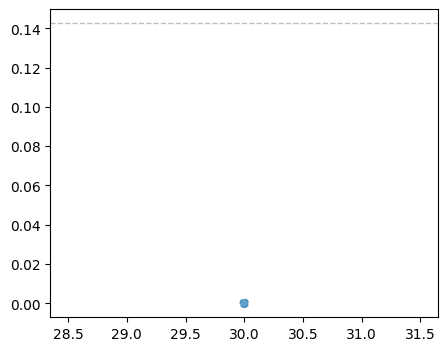

In [45]:
# Pallets and supernatants
# size = 150 * 1e-9
size = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]) * 1e-9
rpms = [1000, 2000, 4000]

# The inital prob
# prob = 0.50
prob = np.array([0.00142615582977985, 2.26662277238378e-05, 1.63968725534759e-05, 0.00222392351341934, 0.453205159317088, 0.2667089252955, 0.165469134181236, 0.0370844302996734, 0.0243730142595645, 0.0307842832504269, 0.0140177811219164, 0.00443854367736452, 0.000228231099404965, 1.35505434733028e-06])

# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))
for rpm in rpms:
    time = 30
    for i in range(len(size)):

        supernate, pallets = cal_supernate_and_pallets(size[i], prob[i], time,
                                                particle_density, liquid_density, liquid_viscosity,
                                                rpm, arm_length, length)
        probs = supernate
        # ax.plot(time, supernate * 1e2, label=f"Supernatant: {rpm/1000}k", alpha = 0.8, linewidth=2) 
        ax.scatter(time, pallets * 1e2, label=f"Pallets: {rpm/1000}k", alpha=0.7, linestyle='--')

        # Add a gray dotted line at y=prob
        ax.axhline(y=probs * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        super_norm = supernate #/ sum(supernate)
        prob = super_norm
    

# ax.set_ylim([0,100])
ax.set_xlim([0,time])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Composition (%)")
ax.set_title(f'Centrifuge Cycles {rpms} of Radius {size * 1e9:.0f}nm')
ax.legend()


need to change/create a function the will return the reduction percent --> this can then be hit on to the existing composition %s and then the pallets and supernates can be normalised


No the normalisation need to be done before the reduction on each end.... or does it happend after-> I think after beacuse the data from the experimental reults are all noramlised to the % compositions. fuck me why are ratios of ratios so hard!!!!

0.0039749665742965234
0.2914347487154213
0.015899866297186094
0.29143474871542113
0.06359946518874432
0.2914349300527818


Text(0, 0.5, 'Composition (%)')

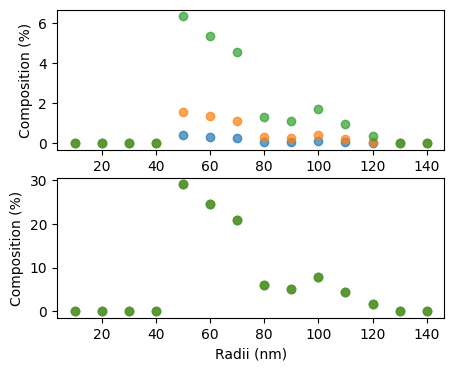

In [52]:
# Pallets and supernatants
# size = 150 * 1e-9
size = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]) * 1e-9
rpms = [1000, 2000, 4000]

# The inital prob
# prob = 0.50
prob = np.array([0.00142615582977985, 2.26662277238378e-05, 1.63968725534759e-05, 0.00222392351341934, 0.453205159317088, 0.2667089252955, 0.165469134181236, 0.0370844302996734, 0.0243730142595645, 0.0307842832504269, 0.0140177811219164, 0.00443854367736452, 0.000228231099404965, 1.35505434733028e-06])

# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(2, figsize=(5,4))
for rpm in rpms:
    time = 30
    pallets = np.zeros(len(size))
    for i in range(len(size)):
        supernate, pallets[i] = cal_supernate_and_pallets(size[i], prob[i], time,
                                                particle_density, liquid_density, liquid_viscosity,
                                                rpm, arm_length, length)
        probs = supernate
        # ax.plot(time, supernate * 1e2, label=f"Supernatant: {rpm/1000}k", alpha = 0.8, linewidth=2) 
    ax[0].scatter(size * 1e9, pallets * 1e2, label=f"Pallets: {rpm/1000}k", alpha=0.7)
    
    pallets_norm = pallets / sum(pallets)
    print(pallets[4])
    print(pallets_norm[4])
    ax[1].scatter(size * 1e9, pallets_norm * 1e2, label=f"Pallets: {rpm/1000}k", alpha=0.7)


        # Add a gray dotted line at y=prob
        # ax.axhline(y=probs * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    

# ax.set_ylim([0,100])
# ax.set_xlim([0,time])

ax[1].set_xlabel("Radii (nm)")
ax[0].set_ylabel("Composition (%)")
ax[1].set_ylabel("Composition (%)")
# ax.set_title(f'Centrifuge Cycles {rpms} of Radius {size * 1e9:.0f}nm')
# ax.legend()

[1.42615583e-03 2.26662277e-05 1.63968726e-05 2.22392351e-03
 4.53205159e-01 2.66708925e-01 1.65469134e-01 3.70844303e-02
 2.43730143e-02 3.07842833e-02 1.40177811e-02 4.43854368e-03
 2.28231099e-04 1.35505435e-06]
[1.42598905e-03 2.26556250e-05 1.63796149e-05 2.21976233e-03
 4.51880170e-01 2.65586086e-01 1.64520955e-01 3.68068754e-02
 2.41421421e-02 3.04242800e-02 1.38194266e-02 4.36379898e-03
 2.23720452e-04 1.32399516e-06]
[1.43183174e-03 2.27165132e-05 1.63851511e-05 2.21321094e-03
 4.48635401e-01 2.62306197e-01 1.61484148e-01 3.58680366e-02
 2.33334851e-02 2.91335609e-02 1.30967794e-02 4.08844282e-03
 2.06975447e-04 1.20809856e-06]
[1.45558848e-03 2.29635488e-05 1.64072081e-05 2.18666606e-03
 4.35559814e-01 2.49162538e-01 1.49391837e-01 3.21568417e-02
 2.01632780e-02 2.41204422e-02 1.03190359e-02 3.04210804e-03
 1.44144361e-04 7.79196923e-07]


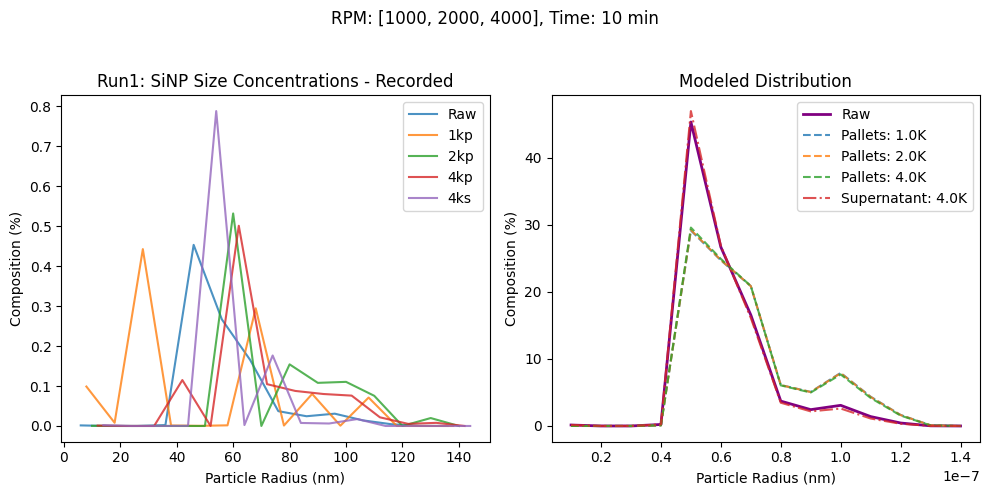

In [110]:
# Parameters
RPMS = [1000, 2000, 4000]

# Initial size distribution - uniform distribution
size = run1['Radii(nm)'].copy().to_numpy() * 1e-9
count = len(size)

# Experimental initial distribution
probability_experimental = run1['Raw'].copy().to_numpy()
print(probability_experimental)

# Centrifugation time (could be named duration)
times = 10

# Set up the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot for run1 (Side-by-side Bars)
mask1 = run1['Radii(nm)'] > 0
radii1 = run1['Radii(nm)'][mask1]

offset = 2
bar_width = offset
ax1 = ax[0]

ax1.plot(radii1 - 2 * offset, run1['Raw'][mask1], linestyle='-', label='Raw', alpha=0.8)
ax1.plot(radii1 - 1 * offset, run1['1kp'][mask1], linestyle='-', label='1kp', alpha=0.8)
ax1.plot(radii1, run1['2kp'][mask1], linestyle='-', label='2kp', alpha=0.8)
ax1.plot(radii1 + offset, run1['4kp'][mask1], linestyle='-', label='4kp', alpha=0.8)
ax1.plot(radii1 + 2 * offset, run1['4ks'][mask1], linestyle='-', label='4ks', alpha=0.8)

# Titles and labels for the first subplot
ax1.set_title("Run1: SiNP Size Concentrations - Recorded")
ax1.set_ylabel("Composition (%)")
ax1.set_xlabel("Particle Radii (nm)")
ax1.legend()

# Plot the initial state of the particle distributions
ax[1].plot(size, probability_experimental * 1e2, label="Raw", linewidth=2, color='purple')

# Loop over each RPM value
for RPM in RPMS:
    # Reset pallets to zero for each run
    pallets_uniformed = np.zeros(count)

    # Loop over each particle size
    for particle in range(count):
        probability_experimental[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(
            size[particle], probability_experimental[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            RPM, arm_length, length
        )
        
    print(probability_experimental)
    # Normalize probabilities and pallets
    probability_experimental /= np.sum(probability_experimental)
    pallets_uniformed /= np.sum(pallets_uniformed)

    # Plot the pallets and supernatant
    ax[1].plot(size , pallets_uniformed * 1e2, label=f"Pallets: {RPM / 1000}K", alpha=0.8, linestyle='--')

ax[1].plot(size , probability_experimental * 1e2, label=f"Supernatant: {RPM / 1000}K", alpha=0.8, linestyle='-.')

# Titles and labels for the second subplot
ax[1].set_title("Modeled Distribution")
ax[1].legend()

fig.suptitle(f"RPM: {RPMS}, Time: {times} min")

# Assigning labels to plot axes
for a in ax:
    a.set_xlabel("Particle Radius (nm)")
ax[1].set_ylabel("Composition (%)")

# Final adjustments and plot display
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [137]:
test = []
print(test == False)

False
